У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
url = "https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data"

In [ ]:
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: evheniiailchenko
Your Kaggle Key: ··········


100%|██████████| 3.29M/3.29M [00:00<00:00, 191MB/s]


Extracting archive ./demand-forecasting-kernels-only/demand-forecasting-kernels-only.zip to ./demand-forecasting-kernels-only


In [ ]:
!ls demand-forecasting-kernels-only

sample_submission.csv  test.csv  train.csv


In [ ]:
import os
import pandas as pd

data_dir = "./demand-forecasting-kernels-only/"
train_csv = data_dir + "train.csv"
data = pd.read_csv(train_csv)
data

date  store  item  sales
0       2013-01-01      1     1     13
1       2013-01-02      1     1     11
2       2013-01-03      1     1     14
3       2013-01-04      1     1     13
4       2013-01-05      1     1     10
...            ...    ...   ...    ...
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82

[913000 rows x 4 columns]

In [ ]:
data['date'] = pd.to_datetime(data['date'])


In [ ]:
data.set_index('date', inplace=True)

In [ ]:
data.head(10)

store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_predict
import seaborn as sns

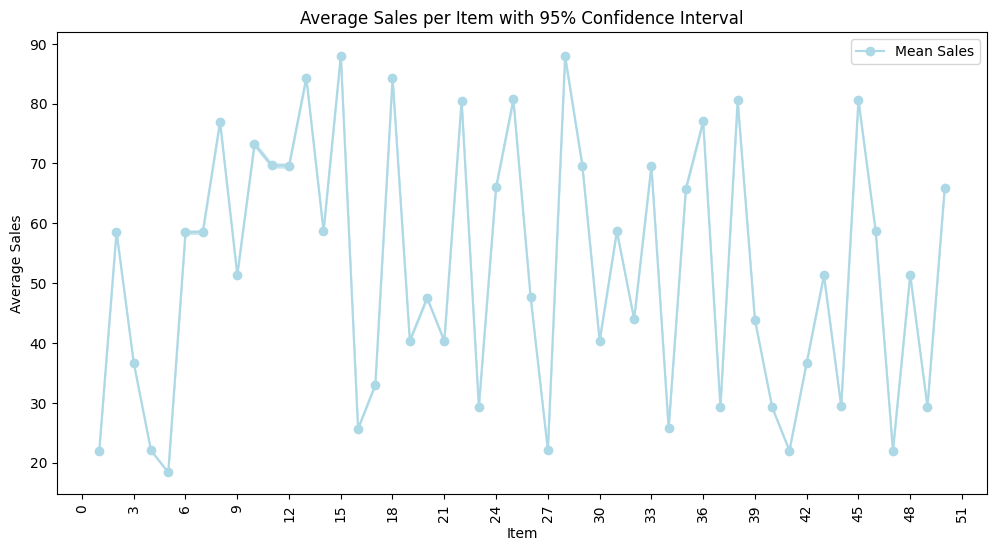

In [ ]:
from matplotlib.ticker import MaxNLocator

item_sales = data.groupby('item')['sales'].agg(['mean', 'std', 'count'])

item_sales['ci'] = 1.96 * item_sales['std'] / np.sqrt(item_sales['count'])

plt.figure(figsize=(12, 6))
plt.plot(item_sales.index, item_sales['mean'], label='Mean Sales', color='lightblue', marker='o')

plt.fill_between(item_sales.index, item_sales['mean'] - item_sales['ci'], item_sales['mean'] + item_sales['ci'], color='lightblue', alpha=0.5)

plt.title('Average Sales per Item with 95% Confidence Interval')
plt.xlabel('Item')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=20))
plt.legend()
plt.show()

**Висновок**

Помітно що середні продажи items дуже розкидані по всім магазинам, що свідчить про високу варіативність в даних;

Не має вираженого тренду;





In [ ]:
sample_items = data['item'].unique()[:5]
df_sample = data[data['item'].isin(sample_items)]
fig = px.line(df_sample,
              x=df_sample.index,
              y='sales',
              color='item',
              labels={'sales': 'Sales', 'index': 'Date', 'item': 'Item'},
              title="Sales Dynamics for Selected Items across Stores")

fig.update_xaxes(tickangle=45)
fig.update_layout(legend_title="Items")
fig.show()

**Висновок**

На графіку помітний патерн по обраним items в розрізі продажів за весь час;

Зростання попиту на більшість товарів з часом;

Сезонні піки попиту, особливо в середині року;


Різні айтеми мають різну стабільність попиту:

Деякі продукти мають стабільніші продажі (Item 1).
Інші можуть мати великі коливання, що може бути пов’язано з фактором попиту або маркетинговими кампаніями (Item 5).


In [ ]:

fig = px.line(data, x=data.index, y='sales', color='store',
              labels={'sales': 'Sales', 'date': 'Date', 'store': 'Store'},
              title='Sales Dynamics for Each Store')

fig.update_xaxes(tickangle=45)
fig.update_layout(legend_title="Stores")
fig.show()

**Висновок**

Видно позитивний тренд по всім магазинам;

Чітка сезонність як і в попредньому графіку;

Піки продажів в різних магазинів відрізняються, але якщо менші продажі то коливання не такі різкі;



3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

**Прорахування вручну**

In [ ]:
filtered_data = data[(data['item'] == 1) & (data['store'] == 1)]
print(filtered_data)

            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
...           ...   ...    ...
2017-12-27      1     1     14
2017-12-28      1     1     19
2017-12-29      1     1     15
2017-12-30      1     1     27
2017-12-31      1     1     23

[1826 rows x 3 columns]


In [ ]:
df_additive = filtered_data.copy(deep=True)
df_additive["trend"] = df_additive["sales"].rolling(window=700, center=True).mean()

# віднімаємо тренд з даних
df_additive["detrended"] = df_additive["sales"] - df_additive["trend"]

# рахуємо сезонну складову як середнє значення ряду пілся віднімання тренду
df_additive["month"] = df_additive.index.month
df_additive["seasonality"] = df_additive.groupby("month")["detrended"].transform("mean")

# обчислюємо залишок як все, що ми не змогли пояснити сезонністю
df_additive["resid"] = df_additive["detrended"] - df_additive["seasonality"]

# що у нас вийшло в результаті
df_additive.head(15)

store  item  sales  trend  detrended  month  seasonality  resid
date                                                                       
2013-01-01      1     1     13    NaN        NaN      1    -5.752805    NaN
2013-01-02      1     1     11    NaN        NaN      1    -5.752805    NaN
2013-01-03      1     1     14    NaN        NaN      1    -5.752805    NaN
2013-01-04      1     1     13    NaN        NaN      1    -5.752805    NaN
2013-01-05      1     1     10    NaN        NaN      1    -5.752805    NaN
2013-01-06      1     1     12    NaN        NaN      1    -5.752805    NaN
2013-01-07      1     1     10    NaN        NaN      1    -5.752805    NaN
2013-01-08      1     1      9    NaN        NaN      1    -5.752805    NaN
2013-01-09      1     1     12    NaN        NaN      1    -5.752805    NaN
2013-01-10      1     1      9    NaN        NaN      1    -5.752805    NaN
2013-01-11      1     1      9    NaN        NaN      1    -5.752805    NaN
2013-01-12      1     1      7    NaN        NaN      1    -5.752805    NaN
2013-01-13      1     1     10    NaN        NaN      1    -5.752805    NaN
2013-01-14      1     1     12    NaN        NaN      1    -5.752805    NaN
2013-01-15      1     1      5    NaN        NaN      1    -5.752805    NaN

<Axes: xlabel='date'>

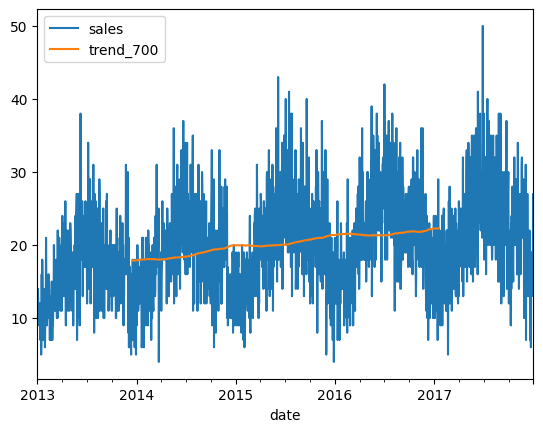

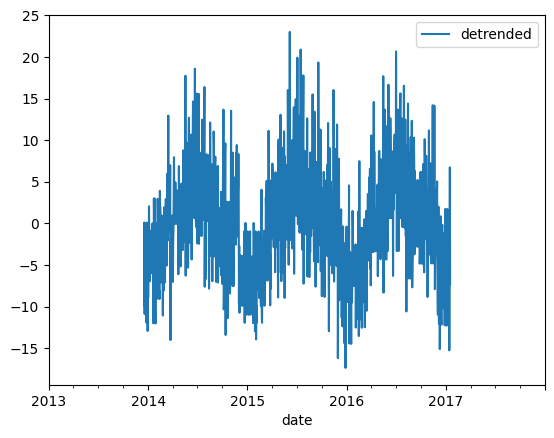

In [ ]:
df_additive["trend_700"] = df_additive["sales"].rolling(window=700, center=True).mean()
df_additive[["sales", "trend_700"]].plot()
df_additive[["detrended"]].plot()

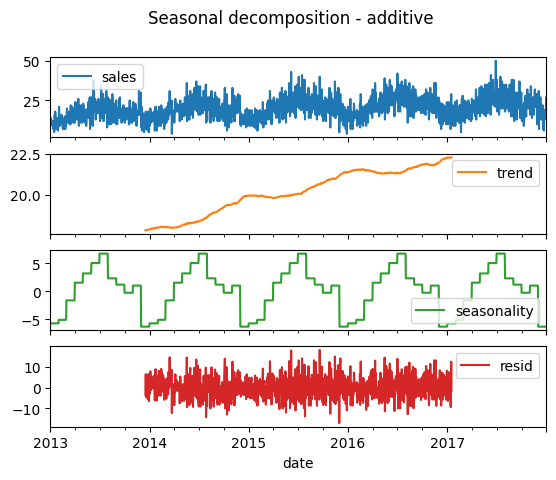

In [ ]:
(
    df_additive
    .loc[:, ["sales", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
);

In [ ]:
data

store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
...           ...   ...    ...
2017-12-27     10    50     63
2017-12-28     10    50     59
2017-12-29     10    50     74
2017-12-30     10    50     62
2017-12-31     10    50     82

[913000 rows x 3 columns]

**Прорахування з бібліотекою**

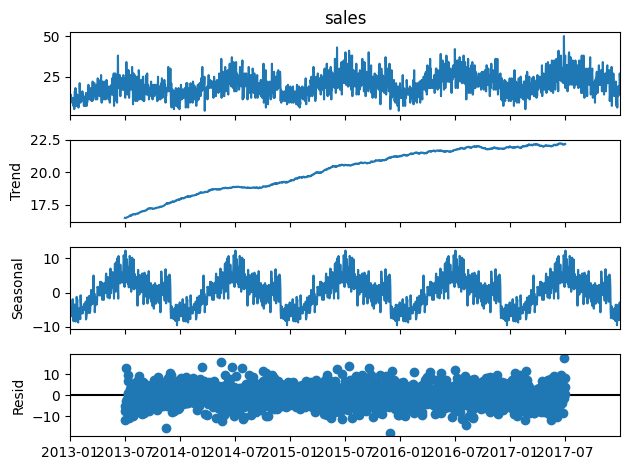

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
period=365

decomposition_plot_multi = seasonal_decompose(x=filtered_data['sales'], model='additive', period=period)
decomposition_plot_multi.plot()
plt.show()

**Висновки**:

Бачимо чітку сезонність - показує виразні коливання з піками та спадами, що відповідають певному циклу, ймовірно, сезонним коливанням попиту,

 тренд - повільне, але стійке зростання значень продажів протягом часового періоду

 резидуали які в межах норми

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [ ]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 972.2/972.2 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00


In [ ]:
from darts import TimeSeries

# Завантаження даних в darts, індекс був перетворений в Darts індекс автоматично
series = TimeSeries.from_dataframe(filtered_data, value_cols='sales')
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

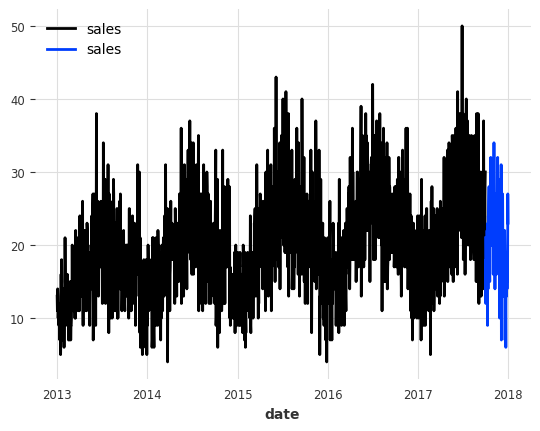

In [ ]:
train, val = series.split_before(pd.Timestamp('2017-10-01'))
train.plot()
val.plot()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

In [ ]:
print(type(series))
print(series.shape)

<class 'darts.timeseries.TimeSeries'>
(1826, 1, 1)


In [ ]:
series_pd = series.pd_series()

<Figure size 1000x600 with 0 Axes>

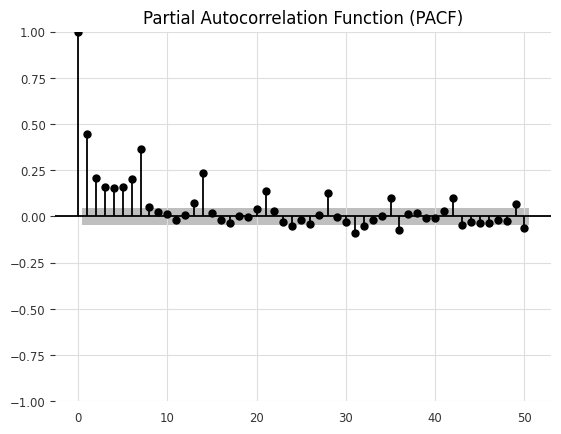

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf


plt.figure(figsize=(10, 6))
plot_pacf(series_pd, lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

Важливими є перші 7, 14, 21, 28, 31, 35, 36, 42 лаги

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

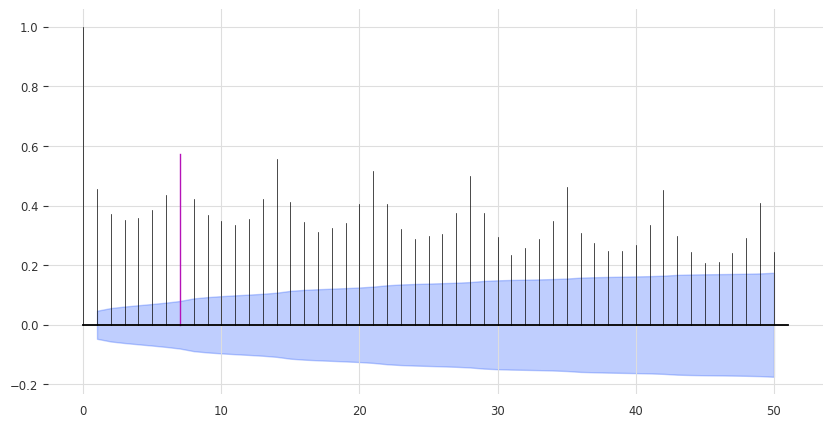

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=7, alpha=0.05, max_lag=50)

In [ ]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

<Axes: xlabel='date'>

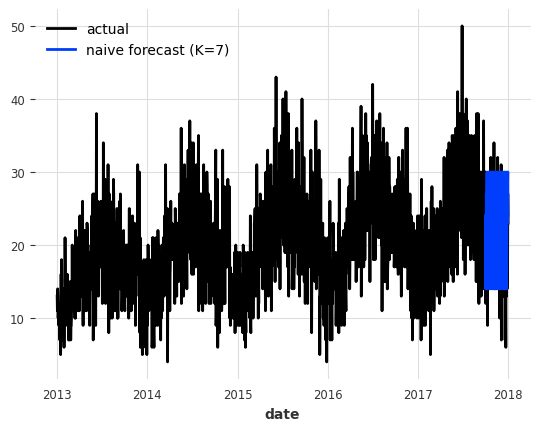

In [ ]:
from darts.models import NaiveSeasonal, NaiveDrift

naive_model = NaiveSeasonal(K=7)
drift_model = NaiveDrift()

naive_model.fit(train)
drift_model.fit(train)

naive_forecast = naive_model.predict(len(val))
drift_forecast = drift_model.predict(len(val))

combined_forecast = drift_forecast + naive_forecast - train.last_value()

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=7)")

<Axes: xlabel='date'>

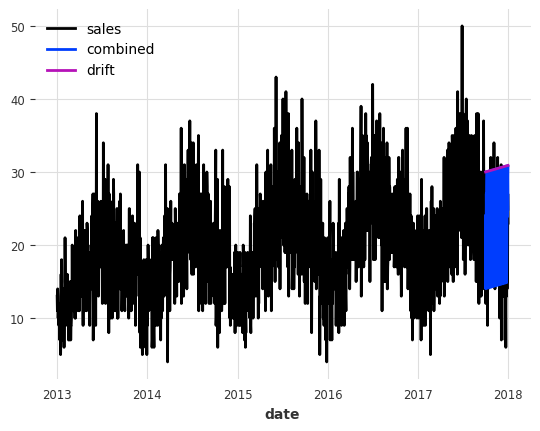

In [ ]:
series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")


Як висновок можна сказати що цю модель можна використати як базову для порівняння, вона не точна

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [ ]:
from darts.metrics import mape

print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(series, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 39.91%.


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [ ]:
from darts.models.forecasting.xgboost import XGBModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

MAPE: 26.38%


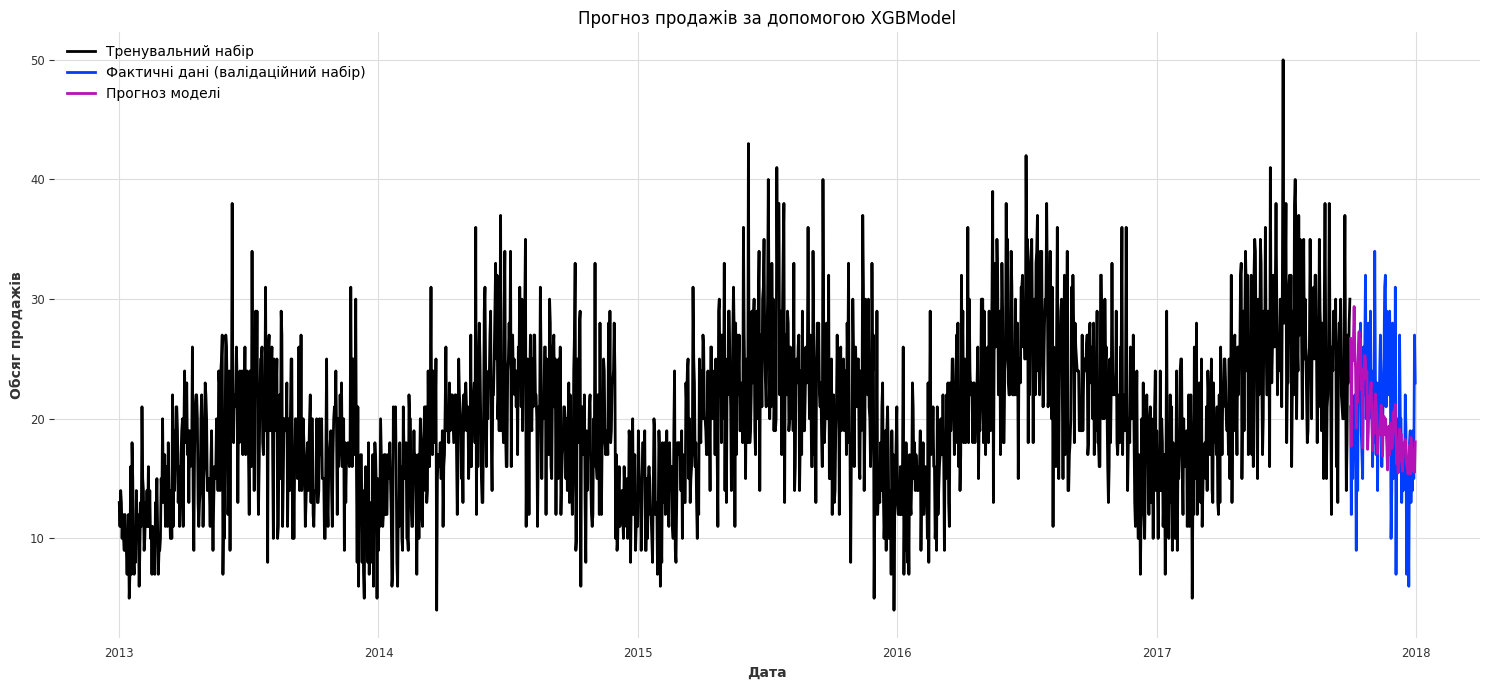

In [ ]:
model = XGBModel(
    lags=7,
    output_chunk_length=3,
    n_estimators=100,
    max_depth=5,
    verbosity=1
)
model.fit(train)

pred = model.predict(n=len(val))

plt.figure(figsize=(15, 7))
train.plot(label='Тренувальний набір')
val.plot(label='Фактичні дані (валідаційний набір)')
pred.plot(label='Прогноз моделі')
plt.legend()
plt.title('Прогноз продажів за допомогою XGBModel')
plt.ylabel('Обсяг продажів')
plt.xlabel('Дата')
plt.tight_layout()

mape_val = mape(val, pred)
print(f"MAPE: {mape_val:.2f}%")


MAPE з днем тижня: 38.07%


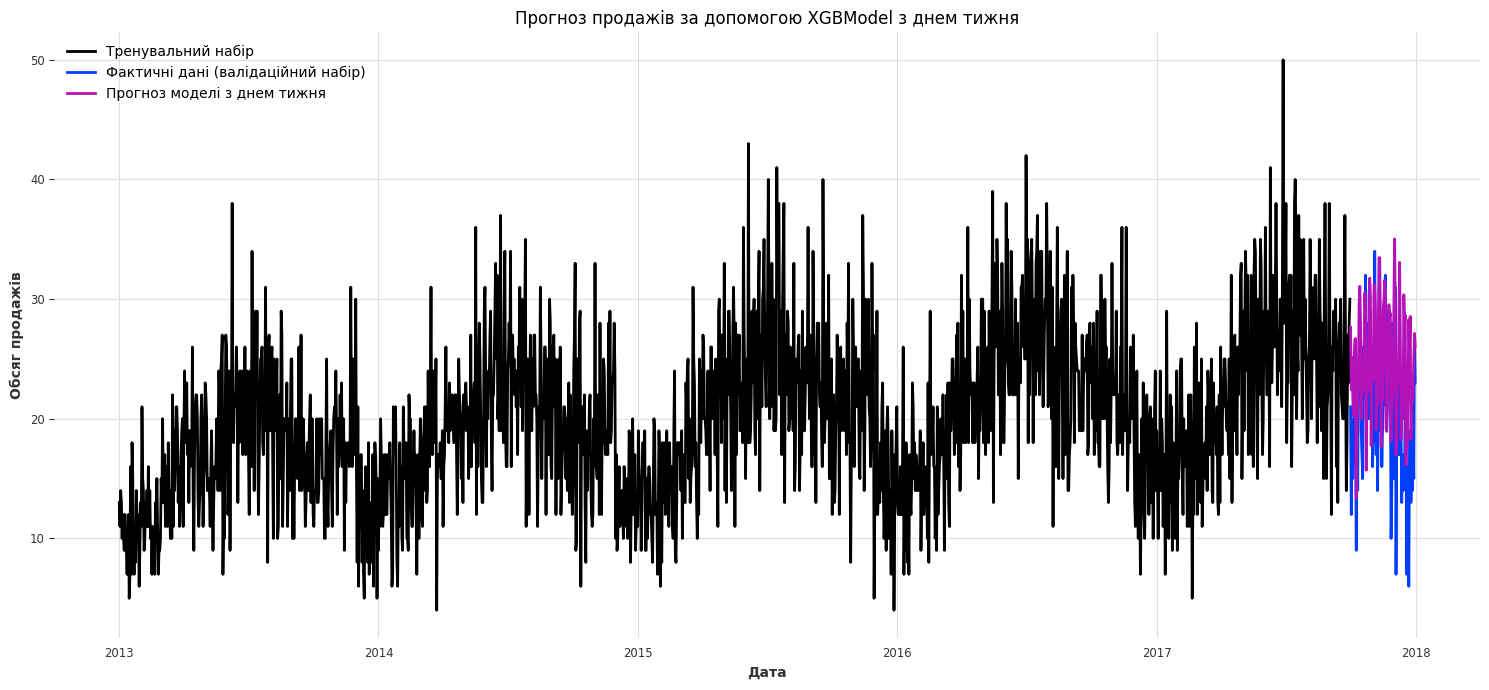

In [ ]:

extended_time_index = pd.date_range(
    start=series.start_time(),
    end=series.end_time() + pd.Timedelta(days=100),
    freq=series.freq_str
)

dayofweek_extended = datetime_attribute_timeseries(
    extended_time_index,
    attribute="dayofweek",
    one_hot=True
)


model_with_dow = XGBModel(
    lags=14,
    output_chunk_length=3,
    n_estimators=100,
    max_depth=5,
    lags_past_covariates=[-1, -2, -7],
    verbosity=1
)

model_with_dow.fit(
    train,
    past_covariates=dayofweek_extended
)

pred_with_dow = model_with_dow.predict(
    n=len(val),
    past_covariates=dayofweek_extended
)

plt.figure(figsize=(15, 7))
train.plot(label='Тренувальний набір')
val.plot(label='Фактичні дані (валідаційний набір)')
pred_with_dow.plot(label='Прогноз моделі з днем тижня')
plt.legend()
plt.title('Прогноз продажів за допомогою XGBModel з днем тижня')
plt.ylabel('Обсяг продажів')
plt.xlabel('Дата')
plt.tight_layout()

mape_with_dow = mape(val, pred_with_dow)
print(f"MAPE з днем тижня: {mape_with_dow:.2f}%")

MAPE з трьома додатковими фічами: 24.98%


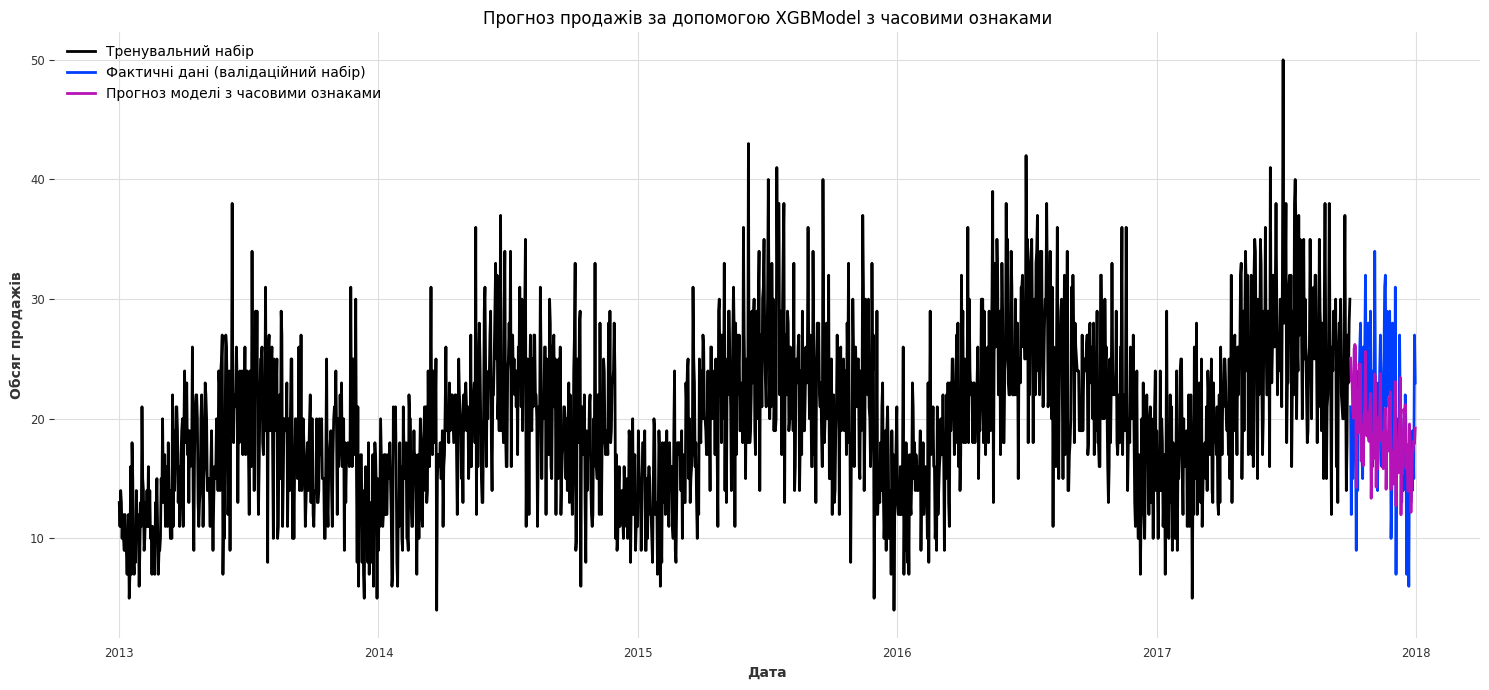

In [ ]:
extended_time_index = pd.date_range(
    start=series.start_time(),
    end=series.end_time() + pd.Timedelta(days=100),
    freq=series.freq_str
)
dayofweek_extended = datetime_attribute_timeseries(
    extended_time_index,
    attribute="dayofweek",
    one_hot=True
)
month_extended = datetime_attribute_timeseries(
    extended_time_index,
    attribute="month",
    one_hot=True
)
day_extended = datetime_attribute_timeseries(
    extended_time_index,
    attribute="day",
    one_hot=True
)


temp_covariates = dayofweek_extended.concatenate(month_extended, axis=1)
all_covariates = temp_covariates.concatenate(day_extended, axis=1)
all_covariates = dayofweek_extended


model_with_features = XGBModel(
    lags=7,
    output_chunk_length=5,
    n_estimators=100,
    max_depth=5,
    lags_past_covariates=[-1, -2, -7],
    verbosity=1
)

model_with_features.fit(
    train,
    past_covariates=all_covariates
)

pred_with_features = model_with_features.predict(
    n=len(val),
    past_covariates=all_covariates
)

plt.figure(figsize=(15, 7))
train.plot(label='Тренувальний набір')
val.plot(label='Фактичні дані (валідаційний набір)')
pred_with_features.plot(label='Прогноз моделі з часовими ознаками')
plt.legend()
plt.title('Прогноз продажів за допомогою XGBModel з часовими ознаками')
plt.ylabel('Обсяг продажів')
plt.xlabel('Дата')
plt.tight_layout()


mape_with_features = mape(val, pred_with_features)
print(f"MAPE з трьома додатковими фічами: {mape_with_features:.2f}%")

**Висновок**

MAPE з трьома додатковими фічами: **24.98%** що є найкращим результатом порівняно з іншими результатами, але гадаю є куди покращувати

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [ ]:
from darts.models import ExponentialSmoothing

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

def fit_eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    eval_forecast(model, val, forecast)


fit_eval_model(ExponentialSmoothing())

model ExponentialSmoothing() obtains MAPE: 39.01%


**Висновок** : базово слабкий результат

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



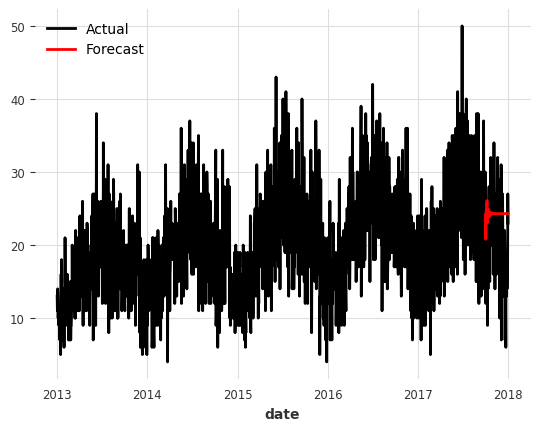

model ARIMA(p=7, q=1) obtains MAPE: 39.53%


In [ ]:
from darts.models import ARIMA

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()
  eval_forecast(model, val, forecast);

model = ARIMA(p=7, d=1, q=1)
fit_and_plot(model, series, train, val)

**Висновок**:

як і очікувалося що ця модель погано працює з сезонністю, тому треба експерементувати з іншими її варіантами

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=4.84 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11699.312, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11207.039, Time=0.92 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10659.514, Time=1.22 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11697.315, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10763.373, Time=0.41 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=7.28 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10587.183, Time=2.43 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=11.43 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=11549.258, Time=1.44 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10580.615, Time=3.05 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10652.927, Time=1.57 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=11.89 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=7.78 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=11181

AutoARIMA(add_encoders=None, start_p=1, max_p=5, start_q=0, max_q=3, d=None, seasonal=True, m=7, information_criterion=aic, trace=True)

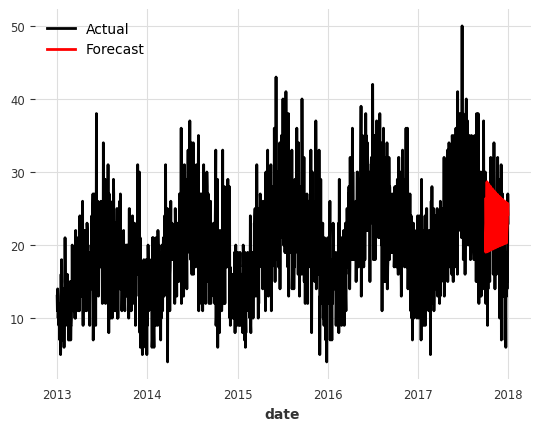

model AutoARIMA(start_p=1, max_p=5, start_q=0, max_q=3, seasonal=True, m=7, information_criterion=aic, trace=True) obtains MAPE: 34.60%


In [ ]:
from darts.models import AutoARIMA
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

model = AutoARIMA(
    start_p=1, max_p=5,
    start_q=0, max_q=3,
    d=None,
    seasonal=True,
    m=7,
    information_criterion='aic',
    trace=True)
model.fit(train)

display(model)
forecast = model.predict(len(val))

series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
eval_forecast(model, val, forecast);

In [ ]:
model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1734
Model:             SARIMAX(3, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -5175.198
Date:                                Mon, 03 Mar 2025   AIC                          10368.395
Time:                                        20:33:21   BIC                          10417.514
Sample:                                             0   HQIC                         10386.562
                                               - 1734                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.302      0.763      -0.002       0.002
ar.L1          0.0858      0.027      3.180      0.001       0.033       0.139
ar.L2          0.0087      0.027      0.323      0.747      -0.044       0.062
ar.L3          0.0367      0.026      1.414      0.157      -0.014       0.088
ma.L1         -0.9563      0.009   -112.293      0.000      -0.973      -0.940
ar.S.L7        0.9521      0.014     69.751      0.000       0.925       0.979
ma.S.L7       -0.8250      0.031    -26.837      0.000      -0.885      -0.765
ma.S.L14       0.0056      0.026      0.212      0.832      -0.046       0.057
sigma2        23.8216      0.795     29.960      0.000      22.263      25.380
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                13.04
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# наша найкраща модель

model = ARIMA(3, 1, 1, seasonal_order=(1, 0, 2, 7))
model.fit(train)
forecast = model.predict(len(val))
eval_forecast(model, val, forecast);

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model ARIMA(p=3, q=1, seasonal_order=(1, 0, 2, 7)) obtains MAPE: 38.61%


**Висновки**:

Best model:  **ARIMA(3,1,1)(1,0,2)[7] intercept**

MAPE: **34.60%**

Таки покращилася якість моделі

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxt9q22wl/mngmhnyx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxt9q22wl/2xwl2q9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85918', 'data', 'file=/tmp/tmpxt9q22wl/mngmhnyx.json', 'init=/tmp/tmpxt9q22wl/2xwl2q9v.json', 'output', 'file=/tmp/tmpxt9q22wl/prophet_modelruq0iwmo/prophet_model-20250303203333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:33:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:33:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


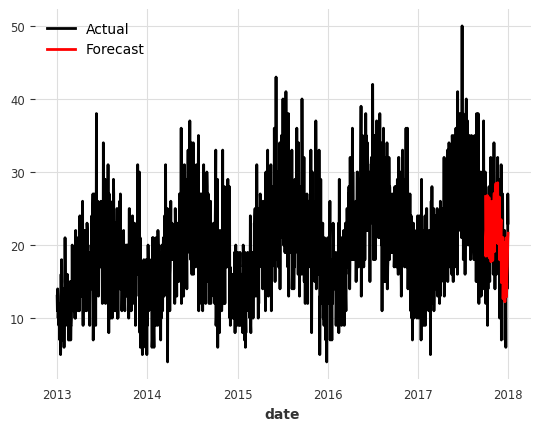

model Prophet() obtains MAPE: 38.61%


38.610083956825314

In [ ]:
from darts.models import Prophet

model_pr = Prophet()
model_pr.fit(train)
forecast_pr = model_pr.predict(len(val))

series.plot(label='Actual')
forecast_pr.plot(label='Forecast', color='red')
plt.legend()
plt.show()
eval_forecast(model_pr, val, forecast)

In [ ]:
model

ARIMA(p=3, d=1, q=1, seasonal_order=(1, 0, 2, 7), trend=None, random_state=None, add_encoders=None)

**Висновки**:

Це найкращий результат за весь час

 MAPE: **23.80%**

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [ ]:
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


2013-01-01 00:00:00 2017-12-31 00:00:00


INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

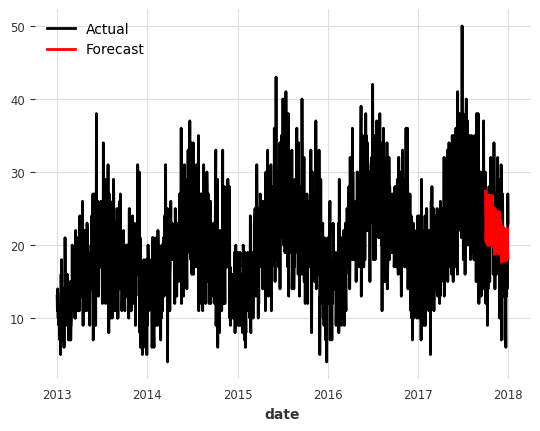

model RNNModel(model=LSTM, hidden_dim=20, training_length=20, input_chunk_length=14, batch_size=16, n_epochs=100, optimizer_kwargs={'lr': 0.001}, log_tensorboard=True, random_state=42, force_reset=True) obtains MAPE: 29.68%


29.677377259277563

In [ ]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler

warnings.filterwarnings("ignore", category=FutureWarning)

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

date_range = series.time_index

# Створення атрибутів року та місяця з двовимірними масивами
year_series = pd.DatetimeIndex(date_range).year.values.reshape(-1, 1)  # Рік
month_series = pd.DatetimeIndex(date_range).month.values.reshape(-1, 1)  # Місяць

# Створення TimeSeries для атрибутів року та місяця
year_series_ts = TimeSeries.from_times_and_values(date_range, year_series)
month_series_ts = TimeSeries.from_times_and_values(date_range, month_series)

# Масштабування атрибутів року та місяця
year_series_scaled = Scaler().fit_transform(year_series_ts)
month_series_scaled = Scaler().fit_transform(month_series_ts)

# Створення коваріатів
covariates = year_series_scaled.stack(month_series_scaled)

# Перевірка діапазону дат у covariates
print(covariates.time_index.min(), covariates.time_index.max())

# Розділяємо на тренувальні та валідаційні дані за датою "2017-10-01"
cov_train, cov_val = covariates.split_before(pd.Timestamp("2017-10-01"))

# Побудова та тренування моделі LSTM
model = RNNModel(
    model="LSTM",
    input_chunk_length=14,
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    force_reset=True,
)

model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True)

forecast = transformer.inverse_transform(model.predict(len(val)))
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

eval_forecast(model, val, forecast)

**Висновок**:

MAPE: **29.68%**

Не найкращий результат з усіх моделей, але точно довший і "важчий" ніж більшість, можливо треба краще підбирати параметри

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

Так як найкраща модель була **Prophet** з оцінкою **23,8%** то бектест робимо з нею

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxt9q22wl/8whxm22k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxt9q22wl/m2szroaz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79790', 'data', 'file=/tmp/tmpxt9q22wl/8whxm22k.json', 'init=/tmp/tmpxt9q22wl/m2szroaz.json', 'output', 'file=/tmp/tmpxt9q22wl/prophet_modelcwbz8b2s/prophet_model-20250303203841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:38:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:38:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxt

MAPE = 29.96%


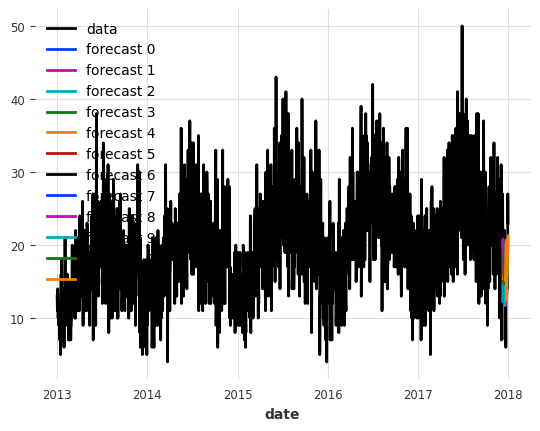

In [ ]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2016-12-01"),
    "forecast_horizon": 12,
    "verbose": False,
}

historical_fcast = model_pr.historical_forecasts(last_points_only=False, stride=1, **hfc_params)

series.plot(label="data")

# Вибір останніх 12 прогнозів
last_12_forecasts = historical_fcast[-12:]

# Прогнозування та виведення результатів для останніх 12 прогнозів
for idx, hfc in enumerate(last_12_forecasts):
    hfc.plot(label=f"forecast {idx}")

from darts import concatenate
historical_fcast_all = concatenate(last_12_forecasts, axis=0, ignore_time_axis=True)

print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxt9q22wl/xl6hgc8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxt9q22wl/ep7fai7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96536', 'data', 'file=/tmp/tmpxt9q22wl/xl6hgc8z.json', 'init=/tmp/tmpxt9q22wl/ep7fai7x.json', 'output', 'file=/tmp/tmpxt9q22wl/prophet_model4vkd9hht/prophet_model-20250303204106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:41:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:41:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxt

MAPE = 21.76%


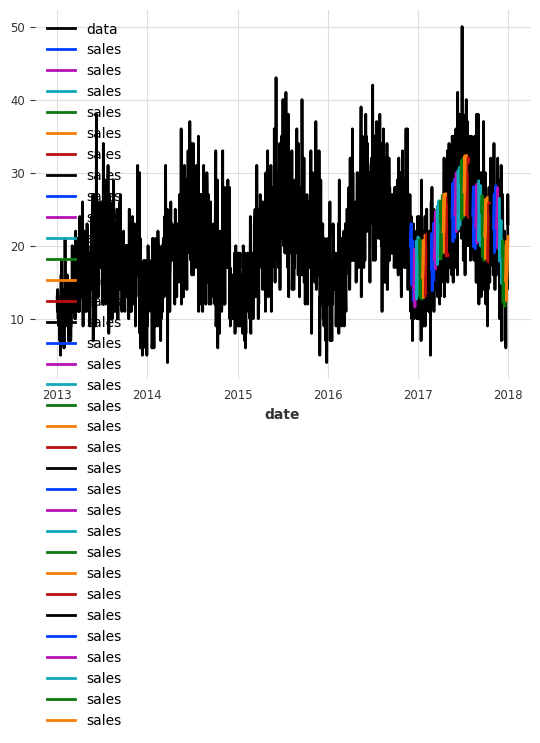

In [ ]:

hfc_params = {
    "series": series,
    "start": pd.Timestamp("2016-12-01"),
    "forecast_horizon": 12,
    "verbose": False,
}

historical_fcast = model_pr.historical_forecasts(last_points_only=False, stride=12, **hfc_params)

series.plot(label="data")
for idx, hfc in enumerate(historical_fcast):
    hfc.plot()

from darts import concatenate
historical_fcast_all = concatenate(historical_fcast, axis=0, ignore_time_axis=True)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

*Виводжу результат картинкою для зручності*

MAPE = 21.76%

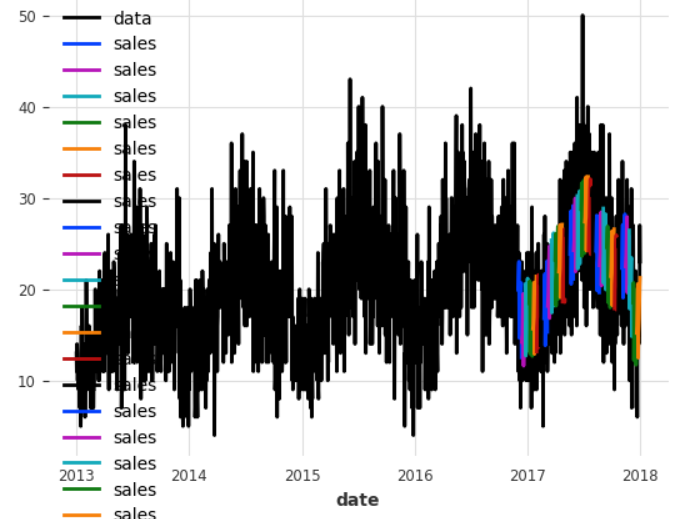

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Я б використовувала **Prophet**

Оскільки в кожному магазині є різні айтеми, продажі кожного айтема можуть мати свою специфічну сезонність та тренди. **Для кожного айтема в кожному магазині потрібно створити окрему модель**.Моделі для кожного айтема та кожного магазину: Якщо вам потрібно прогнозувати продажі для 50 айтемів у 10 магазинах, то вам потрібно **50 x 10 = 500 моделей** (якщо є час та можливість, айтеми відрізняються і треба максимально точні моделі)

Якщо айтеми або магазини мають **схожі сезонні коливання, можна використати однакові моделі з різними параметрами для груп певних айтемів або магазинів**. Наприклад, для групи продуктів однієї категорії можна побудувати одну модель, що буде більш економічно ефективним.

**Альтернативний підхід** — групування моделей:

Якщо певні айтеми мають схожі патерни продажів, можна об'єднати їх в одну модель (наприклад, всі молочні продукти, або товари з однієї категорії). Тоді кількість моделей можна зменшити, тренуючи одну модель для кожної групи. **В цьому випадку кількість моделей буде значно меншою**. Наприклад можна скоротити кількість моделей **до 10 моделей** (по одній для кожної категорії)